In [1]:
from catboost import CatBoostClassifier
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from joblib import load
from sklearn.metrics import accuracy_score
import numpy as np
from scipy.stats import chi2_contingency, fisher_exact
import matplotlib.pyplot as plt


In [2]:
blackbox_model = CatBoostClassifier()
blackbox_model.load_model('../models/catboost_model.dump')

In [3]:
whitebox_model = load('../models/logistic_regression_model.joblib')

## Data Filtering and Preprocessing

We aim at predicting "is_recid". Some features in the dataset must be droped in order to remove features that might be directly linked to the target value, such as "is_violent_recid"

In [4]:
df = utils.read_data_files()
df = df.drop(df[df.is_recid == -1].index)

In [5]:
FEATURES = ['sex', 'age', 'age_cat', 'race',
            'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
            'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
            'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 
            'score_text', 'screening_date',
            'v_decile_score', 'v_score_text',
            'event']

TARGET = ['is_recid']

In [6]:
# Label encode categorical columns
df_encoded = df[FEATURES + TARGET].copy()
label_encoders = {}

for column in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))
    label_encoders[column] = le  # Store the label encoder for each column

# Now all columns should be numeric
X = df_encoded.drop('is_recid', axis=1)
y = df_encoded['is_recid']

In [7]:
# Handle missing values if any
X.fillna(X.mean(), inplace=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
race_mappings = {0: 'African-American', 1: 'Asian', 2: 'Caucasian', 3: 'Hispanic', 4: 'Native American', 5: 'Other'}

## Step 8: Fairness Assessment

To evaluate the fairness of the model we ran Statistical Parity tests on both the black box and white box models. Statistical parity occurs when the decision rate (the proportion of positive outcomes) is the same for all groups defined by the protected attribute. In this case, we are testing whether inmates of all races are evenly predicted to be repeat offenders.

We test for statistical parity globally as well as locally i.e. comparing subgroups of inmates based on their prior counts and age group.

The results confirm that the models are racist.

In [9]:
# prep data
groups = []
predictions = []
decision_rates = []
for i in range(6):
    groups.append(X_test[X_test['race'] == i])

##### 8.1: Statistical Parity Analysis of the Blackbox Model

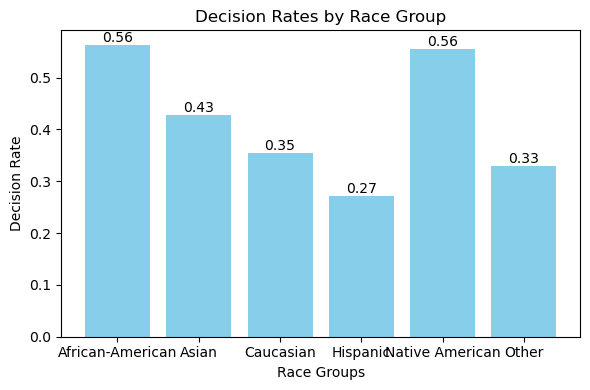

Chi-squared test statistic: 183.7488396915848
P-value: 8.465901632019719e-38
There is a statistically significant difference in decision rates between groups, suggesting a potential fairness issue according to Statistical Parity.


In [10]:
for group in groups:
    preds = blackbox_model.predict(group)
    predictions.append(preds)
    decision_rates.append(np.mean(preds))

contingency_table = []
for preds in predictions:
    positive_outcomes = np.sum(preds)
    negative_outcomes = len(preds) - positive_outcomes
    contingency_table.append([positive_outcomes, negative_outcomes])
chi2, p, dof, ex = chi2_contingency(contingency_table)

plt.figure(figsize=(6, 4))
bar_positions = np.arange(len(decision_rates))
plt.bar(bar_positions, decision_rates, color='skyblue')
plt.xlabel('Race Groups')
plt.ylabel('Decision Rate')
plt.title('Decision Rates by Race Group')
plt.xticks(bar_positions, [race_mappings[i] for i in range(len(decision_rates))])
for i, rate in enumerate(decision_rates):
    plt.text(i, rate, f'{rate:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

print(f'Chi-squared test statistic: {chi2}')
print(f'P-value: {p}')
if p < 0.05:
    print("There is a statistically significant difference in decision rates between groups, suggesting a potential fairness issue according to Statistical Parity.")
else:
    print("There is no statistically significant difference in decision rates between groups according to the chi-squared test.")

The given output from the CatBoost classifier and the chi-squared test indicate that there are disparities in decision rates among different race groups. 

The decision rates vary significantly, with Group 1 having the highest decision rate at approximately 56.31%, and Group 4 having the lowest at approximately 27.07%. The chi-squared test statistic is quite high at 170.43, and the associated p-value is extremely small (around \( 8.45 \times 10^{-36} \) ), which is far below any conventional significance level (e.g., 0.05 or 0.01). This suggests that the differences in decision rates across the groups are statistically significant and not due to random chance.

##### 8.2: Conditional Statistical Parity Analysis of the Blackbox Model

In [11]:
control_variables = ['age_cat', 'priors_count']
unique_values = {var: X_test[var].unique() for var in control_variables}


In [12]:
conditional_results = []

for control_var, values in unique_values.items():
    for value in values:
        stratum_data = X_test[X_test[control_var] == value]
        
        # Loop over racial groups and make predictions
        for race_value in range(6):
            group_data = stratum_data[stratum_data['race'] == race_value]
            if len(group_data) == 0:
                continue
            group_predictions = blackbox_model.predict(group_data[FEATURES])
            
            # Calculate decision rate
            decision_rate = np.mean(group_predictions)
            conditional_results.append({
                'control_variable': control_var,
                'control_value': value,
                'race_value': race_value,
                'decision_rate': decision_rate,
                'sample_size': len(group_predictions)
            })

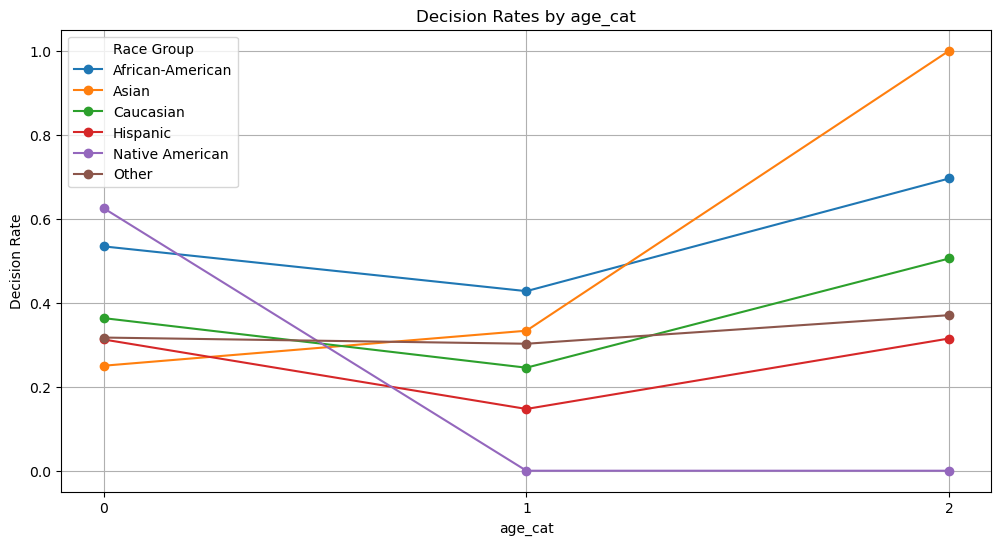

In [13]:
for control_var in control_variables:
    if control_var == 'priors_count':
        continue
    control_values = unique_values[control_var]
    control_values.sort()

    plt.figure(figsize=(12, 6))
    for race_value in range(6):
        decision_rates = []

        for value in control_values:
            race_decision_rates = [x['decision_rate'] for x in conditional_results if x['race_value'] == race_value and x['control_variable'] == control_var and x['control_value'] == value]
            decision_rates.append(race_decision_rates[0] if race_decision_rates else 0)
        plt.plot(control_values, decision_rates, marker='o', label=race_mappings[race_value])
    plt.xlabel(control_var)
    plt.ylabel('Decision Rate')
    plt.title(f'Decision Rates by {control_var}')
    plt.xticks(control_values)
    plt.legend(title="Race Group")
    plt.grid(True)
    plt.show()

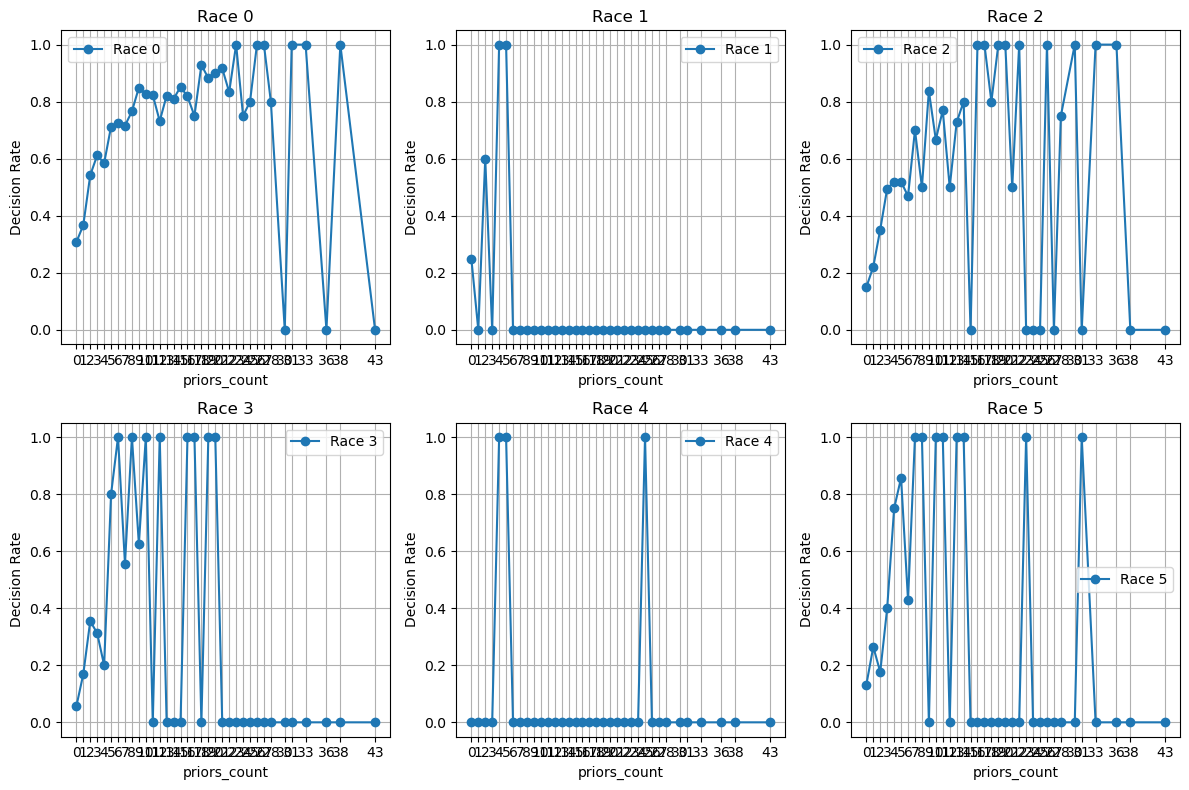

In [14]:
control_var = 'priors_count'
control_values = unique_values[control_var]
control_values.sort()

# Plot each race category in its own subplot
n_subplots = 6
n_cols = 3
n_rows = n_subplots // n_cols + (n_subplots % n_cols > 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))  # Adjusted for better fit
axes = axes.flatten()

for race_value in range(n_subplots):
    decision_rates = []
    for value in control_values:
        race_decision_rates = [x['decision_rate'] for x in conditional_results if x['race_value'] == race_value and x['control_variable'] == control_var and x['control_value'] == value]
        decision_rates.append(race_decision_rates[0] if race_decision_rates else 0)
    ax = axes[race_value]
    ax.plot(control_values, decision_rates, marker='o', label=race_mappings[race_value])
    ax.set_xlabel(control_var)
    ax.set_ylabel('Decision Rate')
    ax.set_title(race_mappings[race_value])
    ax.set_xticks(control_values)
    ax.legend()
    ax.grid(True)
for ax in axes[race_value + 1:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

1. **Initial Unconditional Results**: The initial chi-squared test across all race groups (without conditioning on other variables) shows a very significant result (p-value: \(8.45 \times 10^{-36}\)), indicating strong evidence of disparities in decision rates among the groups. 

2. **Conditional on `age_cat`**:  All three age categories tested show significant chi-squared results, as indicated by very low p-values. This means that even within specific age categories, the decision rates across different race groups are significantly different. 

3. **Conditional on `priors_count`**: Many of the p-values are low (less than 0.05), again indicating significant differences in decision rates across race groups within these specific numbers of prior counts. However, there are instances where the chi-squared test could not be performed reliably due to cells in the contingency table having an expected frequency of less than 5. In such cases, the test may not be valid because the chi-squared test assumes all expected frequencies are at least 5 to ensure sufficient sample size.

4. **Insufficient Data**: For several levels of `priors_count`, particularly the higher counts such as 24, 27, 30, 36, and 38, there were not enough data points to conduct a comparison. This is likely due to a sparse distribution where very few individuals fall into these categories, making it difficult to draw any statistical conclusions about parity at these levels.